# Demo notebook showing arbok functionalities

This is a simple demo notebook containing the core functionalities of arbok

## Installation

To install the arbok python module locally follow the steps below

### 1) Clone github repository
```bash
git clone https://github.com/andncl/arbok.git
```

### 2) Prepare conda environment

```bash
conda create --name <your_env_name>
conda activate <your_env_name>
conda install pip
```

### 3) Go to repo folder and install local arbok module

```bash
pip install -e .
```
**Do not forget the dot after '-e'**. Arbok should now install 
all its requirements automatically. If you need additional
packages, install them in your new environment called <your_env_name>

### Optional) Adding your environment to ipykernel

I recommend running measurements from jupyter lab, which is automatically
installed when executing 3). To pick the environment you just created within
the jupyter lab application, add it to the ipython kernel

```bash
python -m ipykernel install --name <your_env_name>
```

## Lets start with a basic sequence, the square pulse

In [1]:
from arbok.samples.sunshine.control.dummy_control import Square

2023-07-26 11:53:44,393 - qm - INFO     - Starting session: 6a38cc4b-46db-4b96-82bb-e6bca257d0ab


In [2]:
square = Square('square')

`Square` is a class inheriting from `Sequence` and therefore a QCoDeS instrument.

In [3]:
square.amp(0.2)

2023-07-26 11:53:46,960 - qm - INFO     - Performing health check
2023-07-26 11:53:47,770 - qm - INFO     - Health check passed
2023-07-26 11:53:48,363 - qm - INFO     - Simulating program


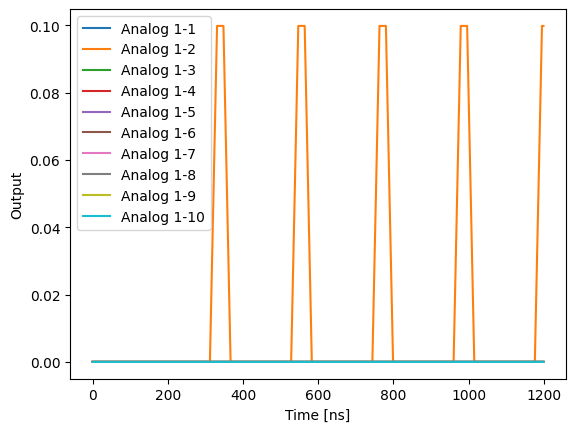

In [4]:
job = square.run_remote_simulation(duration = 300)

### A more realistic example, the SMART C-YY gate 

Firstly we instanciate all `Sequence` objects that should build the entire 
measurement. Since we imported all sequences from the 'arbok.samples.sunshine' 
they already have the config for that specific sample

In [5]:
from arbok.samples.sunshine.readout.up_down_read import UpDownReadout
from arbok.samples.sunshine.initialization.mixed_down_up_init import MixedDownUpInit
from arbok.samples.sunshine.control.smart_Y import SmartY
from arbok.samples.sunshine.control.smart_swap import SmartSwap

In [6]:
duInit = MixedDownUpInit('duInit')
smart_Y1 = SmartY('smartY1')
smart_Y2 = SmartY('smartY2')
smart_swap12 = SmartSwap('smartSwap12')
smart_swap32 = SmartSwap('smartSwap32')
stReadout = UpDownReadout('stReadout')

Next we create an empty `Sequence` class we call 'MEAS' that will structure all 
subsequeces. This time we need to pass a `Sample` since its a unconfigured 
sequence. We create second empty sequence 'CYY' to summarize all control sequences 
(everything happening before readout and after initialization). This is not
mandatory but is helpfull if you want to simulate the entire qubit control part
of the experiment.

In [7]:
from arbok.core.sequence import Sequence
from arbok.core.sample import Sample
from arbok.samples.sunshine.configs.rf2v_config import rf2v_config

In [8]:
sunshine = Sample('sunshine', rf2v_config)

In [9]:
MEAS = Sequence('MEAS', sample = sunshine)
CYY = Sequence('CYY', sample = sunshine)

Thus we add all sub-sequences responsible for qubit control in 'CYY' ...

We used the same class `SmartSwap` to instanciate 'smart_swap12' and 
'smart_swap32' so lets adapt them to not match their exponent. Similarly we 
change the sign of the seconds smart y-gate pulse

In [10]:
smart_swap12.tSwap()

12

In [11]:
smart_swap12.tSwap(6)
smart_swap32.tSwap(24)
smart_swap32.vControlSWAP_J1(0.9)
smart_Y2.vControlY(-0.9)

All parts are now added to the still empty CYY-`Sequence`. The order in which
they are played corresponds to the order how they are added.

In [12]:
CYY.add_subsequence(smart_swap12)
CYY.add_subsequence(smart_Y1)
CYY.add_subsequence(smart_swap32)
CYY.add_subsequence(smart_Y2)

... and finally add initialization, control and readout to the summarizing 
`Sequence`. 

In [13]:
MEAS.add_subsequence(duInit)
MEAS.add_subsequence(CYY)
MEAS.add_subsequence(stReadout)
MEAS.add_subsequence(square)

In [14]:
 #MEAS.print_readable_snapshot()

The readable snapshot get a bit cluttered so lets use an `InstrumentMonitor` to inspect our pulses

In [15]:
from quantify_core.measurement import MeasurementControl
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

In [16]:
meas_ctrl = MeasurementControl('meas_ctrl')
insmon = InstrumentMonitor("InstrumentMonitor")

Note that the QCoDeS `Parameter`s describing the respective sub sequenes are 
saved within their sub classes. The QUA code lives within the sub classes as well
and gets compiled recursively, once we call `get_program()` on the class itself
or on any of its parent sequences. See in the cell below how to access parameters.

In [17]:
MEAS.CYY.smartSwap12.tSwap()

6

In [18]:
MEAS.stReadout.vPreRead_P1()

0.13

In [19]:
MEAS.CYY.submodules

{'smartSwap12': <SmartSwap: smartSwap12>,
 'smartY1': <SmartY: smartY1>,
 'smartSwap32': <SmartSwap: smartSwap32>,
 'smartY2': <SmartY: smartY2>}

In [20]:
MEAS.CYY.smartSwap12.root_instrument

<Sequence: MEAS>

## Simulating Sequences

The entire sequence, any sub group or any sub sequence can now be simulated by
calling `run_remote_simulation` with the desired simulation duration in cycles 
(4ns/cycle). Simulating $\sqrt{SWAP}$ ...

2023-07-26 11:53:58,909 - qm - INFO     - Performing health check
2023-07-26 11:53:59,727 - qm - INFO     - Health check passed
2023-07-26 11:54:00,298 - qm - INFO     - Simulating program


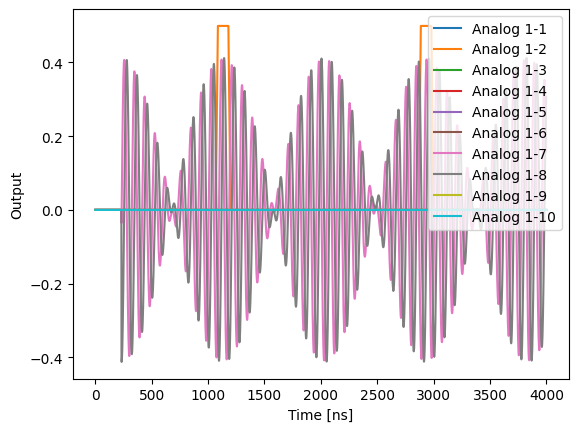

In [21]:
job = MEAS.CYY.smartSwap12.run_remote_simulation(duration = 1000)

... and the entire $CYY$-gate:

2023-07-26 11:54:08,929 - qm - INFO     - Performing health check
2023-07-26 11:54:09,745 - qm - INFO     - Health check passed
2023-07-26 11:54:10,408 - qm - INFO     - Simulating program


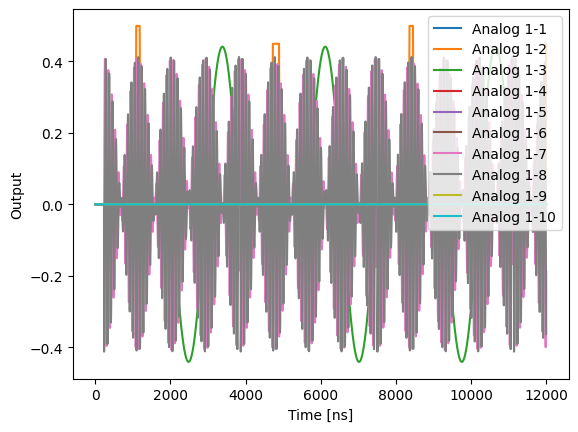

In [22]:
MEAS.CYY.smartY1.smart_cycles(1)
MEAS.CYY.smartY2.smart_cycles(1)
job = MEAS.CYY.run_remote_simulation(duration = 3000)

In [23]:
MEAS.duInit.tInitLoadMixed(40)
MEAS.duInit.tPreControl(55)
MEAS.duInit.tInitPreLoadRamp(200)
MEAS.duInit.tPreControlRampMixed(100)

2023-07-26 11:54:18,105 - qm - INFO     - Performing health check
2023-07-26 11:54:18,935 - qm - INFO     - Health check passed
STREAMING
2023-07-26 11:54:19,942 - qm - INFO     - Simulating program


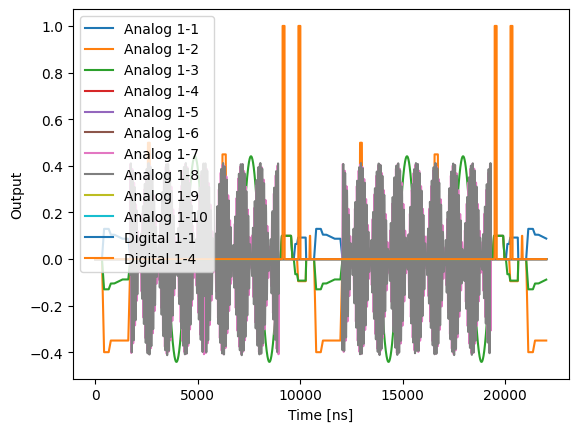

In [24]:
MEAS.run_remote_simulation(duration = 5500)

## Parameter sweeps

Next, we demonstrate parameter sweeps within the QUA script. Choose a `sequence`
you want to simulate and pass a list of QCoDeS parameters you want to sweep, as
well as a numpy array for each of those parameters. The last parameter in the
list corresponds to the innermost loop of the sweep. In the following we only
simulate $\sqrt{SWAP}$ gate while sweeping the delay and duration of the swap
pulse.

In [25]:
import numpy as np

In [26]:
MEAS.square.settables = [MEAS.square.amp, MEAS.square.tSquare]
MEAS.square.setpoints_grid = [ np.linspace(0.1, 1, 3), np.linspace(4, 50, 3) ]

2023-07-26 11:54:30,015 - qm - INFO     - Performing health check
2023-07-26 11:54:30,820 - qm - INFO     - Health check passed
2023-07-26 11:54:31,425 - qm - INFO     - Simulating program


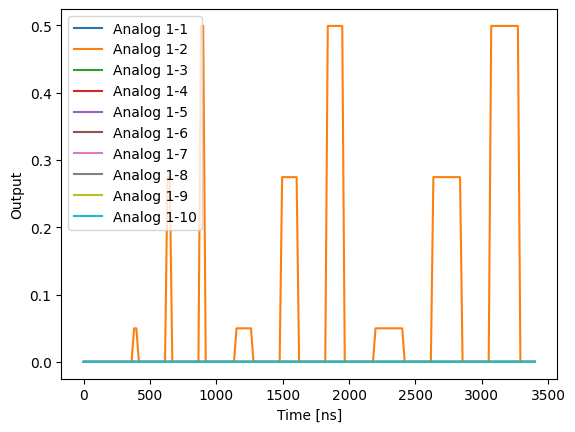

In [27]:
job = MEAS.square.run_remote_simulation(duration = 850)

We can simulate the same parameter sweep for the summarizing `Sequence` 'CYY' as
well, for example to see how pulses align for previous or following sequences.
To do that, we have to add `settables` and the `setpoints_grid` to the sequence
we want to simulate.

In [28]:
MEAS.CYY.settables = [MEAS.CYY.smartSwap12.vControlSWAP_J1, MEAS.CYY.smartSwap12.tSwap]
MEAS.CYY.setpoints_grid = [ np.linspace(0.5, 1, 3), np.linspace(4, 100, 3) ]
MEAS.CYY.smartSwap12.vControlSWAP_J1.batched = True
MEAS.CYY.smartSwap12.tSwap.batched = True

2023-07-26 11:54:37,841 - qm - INFO     - Performing health check
2023-07-26 11:54:38,649 - qm - INFO     - Health check passed
2023-07-26 11:54:39,323 - qm - INFO     - Simulating program


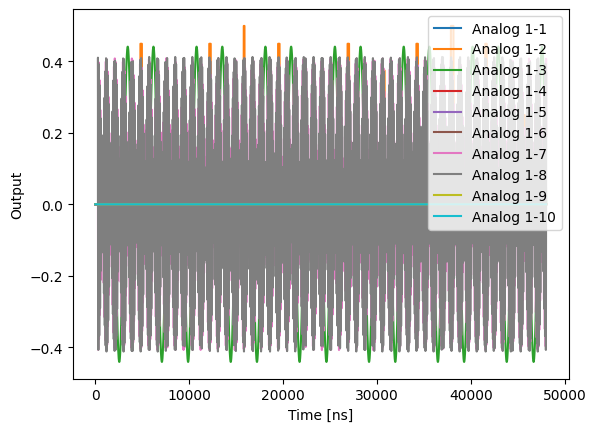

In [29]:
job = MEAS.CYY.run_remote_simulation(duration = 12000)

## Simulating readouts

2023-07-26 11:54:50,702 - qm - INFO     - Performing health check
2023-07-26 11:54:51,518 - qm - INFO     - Health check passed
STREAMING
2023-07-26 11:54:52,309 - qm - INFO     - Simulating program


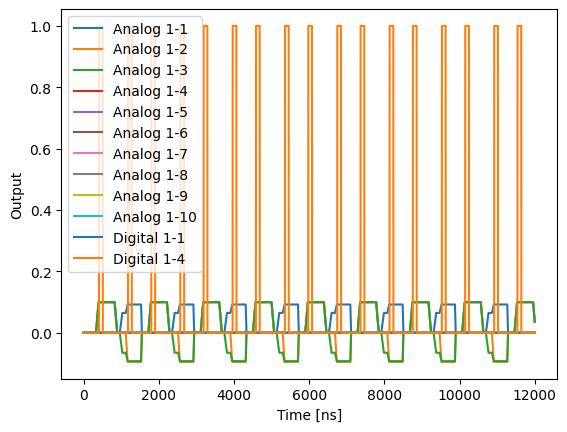

In [30]:
MEAS.CYY.smartSwap12.tWait(int(192))
#job = MEAS.CYY.smartSwap12.run_remote_simulation(duration = 2000)
job = MEAS.stReadout.run_remote_simulation(duration = 3000)

In [31]:
samples = job.get_simulated_samples()

In [32]:
job.result_handles.diff_state.fetch_all()['value']

array([False, False, False, False, False, False, False, False])